In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
import nltk
import re
import string
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Import hate speech CSV
Despite using this CSV in 2 scripts we import it and clean it in each script because the csv isn't very big

In [2]:
data = pd.read_csv(
    "hate_speech_train.csv",
    encoding='latin-1',
    usecols=[1, 2])

# available columns are [0,1,2]=['id', 'label', 'tweet'], we normalize it like the whole project
data.columns = ['polarity', 'text']
data['polarity'] = pd.to_numeric(data['polarity'], downcast='integer')
print(data.head())

   polarity                                               text
0         0   @user when a father is dysfunctional and is s...
1         0  @user @user thanks for #lyft credit i can't us...
2         0                                bihday your majesty
3         0  #model   i love u take with u all the time in ...
4         0             factsguide: society now    #motivation


# Define the function to clean the dataframe

In [3]:
def clean_text(text):
    # remove users tags and url
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())
    # remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    # tokenize
    text = re.split('\W+', text)
    # remove stop-word
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    
    # After testing I've discovered that stemming and lammitization do not improve results
    # Stemming
    #ps = nltk.PorterStemmer()
    #text = [ps.stem(word) for word in text]
    # Lammitization
    #wn = nltk.WordNetLemmatizer()
    #text = [wn.lemmatize(word) for word in text]
    
    # remove empty words
    text = [word for word in text if word != '']
    # rejoin for easier one-hot extraction
    text = ' '.join(text)
    # remove one letters words
    new_text = []
    for w in text.split(" "):
        if len(w) > 1:
            new_text.append(w)
    text = " "
    
    return text.join(new_text)

# Clean the text

In [4]:
data['clean_text'] = data['text'].apply(lambda x: clean_text(x))
data['lower_case_text'] = data.clean_text.map(lambda x: x.lower() if isinstance(x,str) else x)

# Show difference of words between hate tweet and non-hate

hate data vs non-hate-data


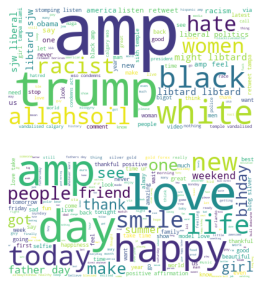

In [13]:
hate_data = data[data['polarity'] == 1]
non_hate_data = data[data['polarity'] == 0]

cloud_stopwords = set(STOPWORDS)

fig = plt.figure(figsize=(20,5))

print("hate data vs non-hate-data")
hate_word_cloud = WordCloud(background_color='white', stopwords=cloud_stopwords).generate(hate_data['lower_case_text'].str.cat(sep=', '))
ax = fig.add_subplot(2,1,1)
plt.imshow(hate_word_cloud)
ax.axis('off')

non_hate_word_cloud = WordCloud(background_color='white', stopwords=cloud_stopwords).generate(non_hate_data['lower_case_text'].str.cat(sep=', '))
ax = fig.add_subplot(2,1,2)
plt.imshow(non_hate_word_cloud)
ax.axis('off')


# We delete both df because we won't use them after
del hate_data, non_hate_data

# Split test/train data

In [6]:
df_train, df_test = train_test_split(data, test_size=0.25, random_state=1, shuffle=True)

# Convert text to vector with TfIdf

In [7]:
tokenizer = TweetTokenizer().tokenize

vect_tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', ngram_range=(1,3), max_df=0.3)
vect_tfidf.fit(df_train['lower_case_text'].values)

X_train = vect_tfidf.transform(df_train['lower_case_text'].values)
X_test = vect_tfidf.transform(df_test['lower_case_text'].values)

print(f'''X_train shape = {X_train.shape}''')

y_train = df_train.polarity.values.copy()
y_test = df_test.polarity.values.copy()

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


X_train shape = (23971, 246285)


# Oversample train data with SMOTE
Results where not better with it so the main line is commented

In [8]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# transform the dataset
oversample = SMOTE()
#X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)
print(counter)

Counter({0: 22269, 1: 1702})


# Build logistic regression model

In [9]:
logreg = LogisticRegression(n_jobs=-1,C= 10, class_weight= 'balanced', penalty= 'l2', random_state= 1)

logreg.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', n_jobs=-1, random_state=1)

# Make prediction

In [10]:
y_pred = logreg.predict(X_test)

# Evaluate model performance
We do not use accuracy because the dataset is unbalanced, we use f1_score which is a combination of both accuracy and recall 

[[7258  193]
 [ 141  399]]


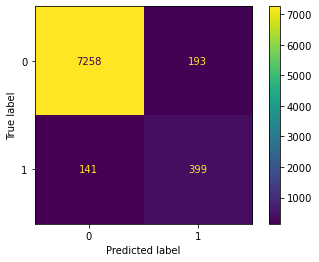

In [11]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

plot_confusion_matrix(logreg, X_test, y_test)
plt.show()

In [12]:
print("f1_score of the model : ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1_score of the model :  0.7049469964664312
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      7451
           1       0.67      0.74      0.70       540

    accuracy                           0.96      7991
   macro avg       0.83      0.86      0.84      7991
weighted avg       0.96      0.96      0.96      7991

